## CLASSIQ 2024 MEGA CHALLENGE SOLUTION
Author: Francisco Granda

Welcome to my solution for the Classiq 2024 mega challenge. Through this journey, we'll follow the implementation of the Symmetry Enhanced Quantum Spin Eigensolver and analyze the results for the following circuits: 

- Hardware-Efficient Ansatz Circuit
- $S_z$-Conserving Ansatz Circuit
- $S_{\text{tot}}$-Conserving Ansatz Circuit

Before we start, we need some proper tools:

In [56]:
# Handle imports
from classiq import * # Using Classiq Version 0.52.0 Release
import numpy as np
from typing import cast, List
from classiq.execution import ExecutionPreferences
import matplotlib.pyplot as plt
import json
import os

Then, the circuit implementations can be created using Classiq's quantum functions. First, we start with the entangling gate between two Qubits. Here it is important to notice that Chufan Lyu et al. use one parameter for all the rotations in the gate, in this case called "layer". This gate will be used throughout this solution so we define it here first:

In [42]:
# N block function
@qfunc
def N_block(q0: QBit, q1: QBit, layer: CReal) -> None:
    RZ(np.pi / 2, q1)

    CX(q1, q0)
     
    RZ(2 * layer - np.pi/2, q0)
    RY(np.pi / 2 - 2 * layer, q1)
    
    CX(q0, q1)

    RY(2 * layer - np.pi/2, q1)

    CX(q1, q0)
    RZ(-np.pi / 2, q0)

After this, we can build the main layer of the hardware-efficient Ansatz:

In [43]:
# Main ansatz layer
@qfunc
def hw_efficient_layer(q: QArray, params: CArray[CReal]) -> None:
    # Apply the rotations first
    param_idx = 0

    # Start with the RY's
    for i in range(n_bits):
        RY(params[param_idx], q[i])
        param_idx += 1

    # Continue with the RZ's
    for i in range(n_bits):
        RZ(params[param_idx], q[i])
        param_idx += 1

    # Apply the Hadamard/CNOT chains
    for i in range(0,n_bits-1):
        hadamard_transform(q[i+1])
        CX(q[i],q[i+1])
        hadamard_transform(q[i+1])

Then we proceed with the main layer for the $S_z$-Conserving Ansatz:

In [44]:
# Main ansatz layer
@qfunc
def Sz_conserving_layer(q: QArray, params: CArray[CReal]) -> None:
    # Apply the N_block layer for entangling
    param_idx = 0
    for i in range(0, n_bits, 2):
        N_block(q[i],q[i+1], params[param_idx])
        param_idx += 1

    for i in range(1, n_bits - 1, 2):
        N_block(q[i],q[i+1], params[param_idx])
        param_idx += 1

    # Apply the Phase Gates
    for i in range(n_bits):
        PHASE(params[(n_bits-1)+i], q[i])

Finally, the layer for the $S_{\text{tot}}$-Conserving Ansatz is defined:

In [45]:
# Main ansatz layer
@qfunc
def Stot_conserving_layer(q: QArray, params: CArray[CReal]) -> None:
    # Apply the N_block layer for entangling
    param_idx = 0
    for i in range(0, n_bits, 2):
        N_block(q[i],q[i+1], params[param_idx])
        param_idx += 1

    for i in range(1, n_bits - 1, 2):
        N_block(q[i],q[i+1], params[param_idx])
        param_idx += 1

Before we continue, the $S_{\text{tot}}$-Conserving Ansatz needs an additional initialization block. This is defined as follows:

In [46]:
# Initialization circuit layer
@qfunc
def Init(q: QArray) -> None:
    # First, do PauliX on all qubits
    for i in range(n_bits):
        X(q[i])

    # Next, add the Hadamards and CNOT
    for i in range(0, n_bits, 2):
        hadamard_transform(q[i])
        CX(q[i],q[i + 1])

Now, we need to switch gears and focus on the creation of the Hamiltonian that will act as the observable for the optimization. For this, Pauli strings can be created to define the actions over the Qubits:

In [47]:
# Function to build the Paulis string
def build_pauli_string(N: int, J: float) -> list[tuple[str, float]]:
    pauli_list = []
    
    # Loop over each neighboring pair of spins (i, i+1)
    for i in range(N-1):
        # Create Pauli strings 
        for pauli in ['X', 'Y', 'Z']:
            # Identity for other positions, Pauli for position i and i+1
            identity = ['I'] * N
            identity[i] = pauli
            identity[i+1] = pauli
            
            # Join Pauli string and add it to the list with coefficient J
            pauli_string = ''.join(identity)
            pauli_list.append((pauli_string, J))
    
    return pauli_list

This looks great, but it is not enough by itself. To proceed, the operations need to be translated into Classiq classes:

In [48]:
# Definition of Pauli Terms
CHAR_TO_STUCT_DICT = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

# Functions for creating the Hamiltonian from the Paulis String
def pauli_str_to_enums(pauli):
    return [CHAR_TO_STUCT_DICT[s] for s in pauli]

Great! Now we can finally build our Hamiltonian:

In [49]:
def pauli_list_to_hamiltonian(pauli_list):
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]

Now, we need to define some variables for the experiments:

In [50]:
# Circuit design variables
n_bits = 4
n_layers = 5
J = 1

Also, it will be useful to identify and define the number of parameters that the circuits will have based on the chosen Ansatz and number of layers and Qubits. We start with the hardware-efficient Ansatz:

In [51]:
# For HW-Efficient
param_per_layer = n_bits * 2 # The RY's and RZ's
num_parameters = param_per_layer*n_layers
JOB_NAME = "".join(("HW_efficient | ","N_bits:",str(n_bits)," Layers:",str(n_layers)))

Then we move on to build the Hamiltonian and create a vector of random initial values for the optimization process and create Quantum Function for the main circuit:

In [52]:
# Create the pauli list
pauli_list = build_pauli_string(n_bits,J)
# Create the Hamiltonian
heis_ham = pauli_list_to_hamiltonian(pauli_list)
# Defining the Hamiltonian from the problem
HAMILTONIAN = QConstant("HAMILTONIAN", List[PauliTerm], heis_ham)

# Defining the initial parameter values
X0 = list(np.random.rand(num_parameters) * np.pi)
INITIAL_POINT = QConstant("INITIAL_POINT", List[float],X0)

# Defining the Ansatz for the Problem
@qfunc
def main(q: Output[QArray], p: CArray[CReal, num_parameters]) -> None:
    allocate(n_bits, q)
    # Prepare the initial state
    # [1010....10]
    for i in range(n_bits):
        if i % 2 != 0:
            X(q[i])

    # Do n layers of the Sz_conserving Ansatz
    for i in range(n_layers):
        start_index = i * param_per_layer
        end_index = start_index + param_per_layer
        hw_efficient_layer(q, p[start_index:end_index])

At this point, we can proceed with a classical function to solve the hybrid optimization problem. For this we can use Classiq's VQE execution primitive to find a solution:

In [53]:
# Defining the Variational Quantum Eigensolver primitives with proper parameters
@cfunc
def cmain() -> None:
    res = vqe(
        hamiltonian=HAMILTONIAN,
        maximize=False,
        initial_point=INITIAL_POINT,
        optimizer=Optimizer.COBYLA, # Classical Optimizer
        max_iteration=5000,
        tolerance=1e-06,
        step_size=0,
        skip_compute_variance=False,
        alpha_cvar=1,
    )
    save({"result": res})

Then we proceed with creating the model, synthesizing, and execution. The steps in this notebook can be modified and run to observe results for different Qubit numbers and layers

In [54]:
# Model, preferences and synthesize
qmod = create_model(main, classical_execution_function=cmain)
qmod_prefs = set_execution_preferences(
    qmod,
    ExecutionPreferences(num_shots=10000, job_name=JOB_NAME),
)
qprog = synthesize(qmod_prefs)

# Execution
estimation = execute(qprog)
vqe_result = estimation.result()[0].value
print("Minimal energy of the Hamiltonian", vqe_result.energy)

Minimal energy of the Hamiltonian -5.256


For the hardware-efficient Ansatz we can obtain the following results:

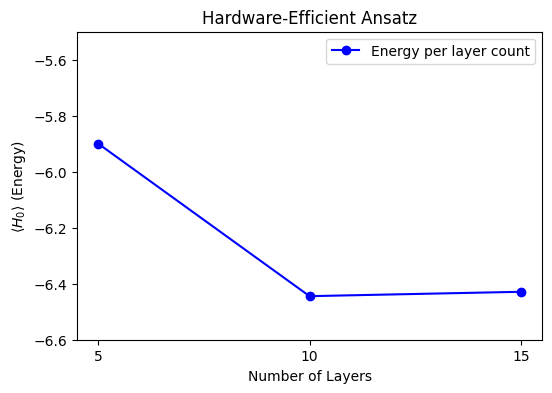

In [71]:
# X-axis values representing the number of layers
layers = [5, 10, 15]
energies = [-5.8996, -6.4444, -6.4288]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(layers, energies, 'o-', color='blue', label='Energy per layer count')

# Axis labels
plt.xlabel("Number of Layers")
plt.ylabel(r"$\langle H_0 \rangle$ (Energy)")

# Set y-axis range
plt.ylim(-6.6, -5.5)

# Ticks and legend
plt.xticks([5, 10, 15])
plt.legend()

# Title
plt.title("Hardware-Efficient Ansatz")

# Display the plot
plt.show()

We analyze that for 5 layers, the results is significantly off from the values show for 10 and 15 layers. 

Further analysis will be added at the end, but for now let's proceed with the implementation of the $S_z$-Conserving Ansatz:

In [59]:
# Determine the # of parameters
param_per_layer = (n_bits - 1)+n_bits # The N_Blocks + the Phase gates
num_parameters = param_per_layer*n_layers
X0 = list(np.random.rand(num_parameters) * 20 * np.pi)
INITIAL_POINT = QConstant("INITIAL_POINT", List[float], X0)
# Defining the Ansatz for the Problem
@qfunc
def main(q: Output[QArray], p: CArray[CReal, num_parameters]) -> None:
    allocate(n_bits, q)
    # Prepare the initial state
    # [1010....10]
    for i in range(n_bits):
        if i % 2 != 0:
            X(q[i])

    # Do n layers of the Sz_conserving Ansatz
    for i in range(n_layers):
        start_index = i * param_per_layer
        end_index = start_index + param_per_layer
        Sz_conserving_layer(q, p[start_index:end_index])

# Defining the Variational Quantum Eigensolver primitives with proper paramters
@cfunc
def cmain() -> None:
    res = vqe(
        hamiltonian=HAMILTONIAN,
        maximize=False,
        initial_point=[],
        optimizer=Optimizer.COBYLA, # Classical Optimizer
        max_iteration=5000,
        tolerance=1e-06,
        step_size=0,
        skip_compute_variance=False,
        alpha_cvar=1,
    )
    save({"result": res})

# Model, preferences and synthesize
qmod = create_model(main, classical_execution_function=cmain)
qmod_prefs = set_execution_preferences(
    qmod,
    ExecutionPreferences(num_shots=10000, job_name=JOB_NAME),
)
qprog = synthesize(qmod_prefs)

# Execution
estimation = execute(qprog)
vqe_result = estimation.result()[0].value
print("Minimal energy of the Hamiltonian", vqe_result.energy)

Minimal energy of the Hamiltonian -6.4732


For the $S_z$-Conserving Ansatz: we can obtain the following results:

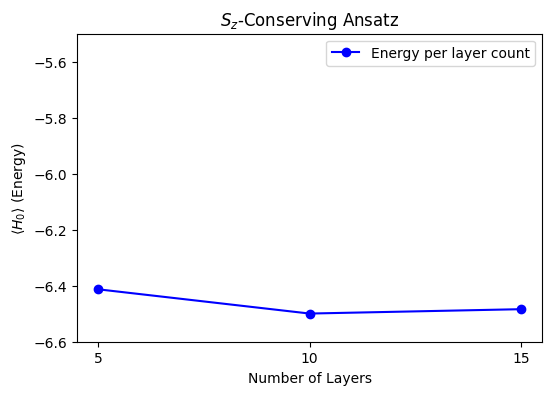

In [70]:
# X-axis values representing the number of layers
layers = [5, 10, 15]
energies = [-6.41280, -6.4994, -6.4838]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(layers, energies, 'o-', color='blue', label='Energy per layer count')

# Axis labels
plt.xlabel("Number of Layers")
plt.ylabel(r"$\langle H_0 \rangle$ (Energy)")

# Set y-axis range
plt.ylim(-6.6, -5.5)

# Ticks and legend
plt.xticks([5, 10, 15])
plt.legend()

# Title
plt.title("$S_z$-Conserving Ansatz")

# Display the plot
plt.show()

Here, it is noticeable that the results are converging to the proper energy value even when 5 layers are used. 

Let's proceed with the $S_{\text{tot}}$-Conserving Ansatz:

In [61]:
# Determine the # of parameters
param_per_layer = n_bits - 1 # Just the N_Blocks
num_parameters = param_per_layer*n_layers

# Defining the initial parameter values
X0 = list((np.random.rand(num_parameters) - .5) * np.pi)
INITIAL_POINT = QConstant("INITIAL_POINT", List[float],X0)

# Defining the Ansatz for the Problem
@qfunc
def main(q: Output[QArray], p: CArray[CReal, num_parameters]) -> None:
    allocate(n_bits, q)
    # Prepare the initial state
    Init(q)
    
    # Do n layers of the Sz_conserving Ansatz
    for i in range(n_layers):
        start_index = i * param_per_layer
        end_index = start_index + param_per_layer
        Stot_conserving_layer(q, p[start_index:end_index])

# Defining the Variational Quantum Eigensolver primitives with proper paramters
@cfunc
def cmain() -> None:
    res = vqe(
        hamiltonian=HAMILTONIAN,
        maximize=False,
        initial_point=[],
        optimizer=Optimizer.COBYLA, # Classical Optimizer
        max_iteration=5000,
        tolerance=1e-06,
        step_size=0,
        skip_compute_variance=False,
        alpha_cvar=1,
    )
    save({"result": res})

# Model, preferences and synthesize
qmod = create_model(main, classical_execution_function=cmain)
qmod_prefs = set_execution_preferences(
    qmod,
    ExecutionPreferences(num_shots=10000, job_name=JOB_NAME),
)
qprog = synthesize(qmod_prefs)

# Execution
estimation = execute(qprog)
vqe_result = estimation.result()[0].value
print("Minimal energy of the Hamiltonian", vqe_result.energy)

Minimal energy of the Hamiltonian -6.496


For the $S_{\text{tot}}$-Conserving Ansatz we can obtain the following results:

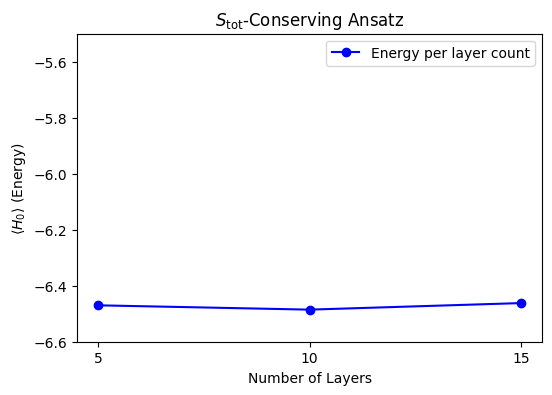

In [69]:
# X-axis values representing the number of layers
layers = [5, 10, 15]
energies = [-6.4700, -6.4854, -6.462]

# Plotting
plt.figure(figsize=(6, 4))
plt.plot(layers, energies, 'o-', color='blue', label='Energy per layer count')

# Axis labels
plt.xlabel("Number of Layers")
plt.ylabel(r"$\langle H_0 \rangle$ (Energy)")

# Set y-axis range
plt.ylim(-6.6, -5.5)

# Ticks and legend
plt.xticks([5, 10, 15])
plt.legend()

# Title
plt.title("$S_{\\text{tot}}$-Conserving Ansatz")

# Display the plot
plt.show()

Here, we find similar results to the $S_z$-Conserving Ansatz where even 5 layers are able to result in a good estimate of the ground state energy of the system. 

### PROCESSING TIME AND IMPACT OF INITIAL PARAMETERS

The variation of the initial parameters proved to offer some benefits in reducing the processing time until convergence. When the optimal parameters of a previously trained model were used as initial parameters, a time reduction of approximately 26% was observed. 

However, these results will vary based on the optimizer that is chosen. For instance, gradient based optimizers will be able to converge to a solution almost instantly if the previously trained parameters are used as an initial guess.

### CONCLUSIONS, FUTURE WORK AND CONTACT
The selection of a proper ansatz is crucial when using VQA's for solving optimization problems. In this notebook, we observe results for n_bits = 4 that are following similar trends to the results presented in the paper.

As additional test for the implementation proposed in this paper, I prepared the circuits to be used with Pennylane and observed the results for the ground state of a H2 molecule, where great estimates of the ground state energy were obtained. 

Please do not hesitate to contact me if any additional information is required, I had a blast working on this challenge and really enjoyed making this tutorial/journey through my solution.